## 1.读取package

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.base import BaseEstimator, ClusterMixin, clone
import pickle
import warnings
from sklearn.utils import check_random_state
from fcmeans import FCM
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cdist
from sklearn.metrics import normalized_mutual_info_score
from tqdm import tqdm  # Import tqdm for progress bars
from scipy.stats import sem
from scipy.stats import t
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
np.random.seed(2024)
random_state = check_random_state(2024)

class FCMWrapper(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=2, fuzziness=2.0, max_iter=1000, error=1e-5, random_state=2024, init='k-means++'):
        self.n_clusters = n_clusters
        self.fuzziness = fuzziness
        self.max_iter = max_iter
        self.error = error
        self.random_state = random_state
        self.init = init
        
    def fit(self, X, y=None):
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        kmeans = KMeans(n_clusters=self.n_clusters, init=self.init, random_state=self.random_state)
        kmeans.fit(X)
        initial_centers = kmeans.cluster_centers_
        
        self.fcm = FCM(n_clusters=self.n_clusters, m=self.fuzziness, max_iter=self.max_iter, error=self.error, 
                       random_state=self.random_state, initial_centers=initial_centers)
        self.fcm.fit(X)
        return self
    
    def predict(self, X):
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        return self.fcm.predict(X)
    
    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.predict(X)
    
    @property
    def u_(self):
        return self.fcm.u
    
    @property
    def centers(self):
        return self.fcm.centers
    
    def fuzzy_partition_coefficient(self):
        u = self.u_
        return np.sum(u ** 2) / u.shape[0]  # 计算 Fuzzy Partition Coefficient (FPC)


def kwons_v_k_score_func(estimator, X):
    u = estimator.u_
    centers = estimator.centers
    distances = cdist(X, centers, metric='sqeuclidean')
    score = np.sum(u * distances)
    return (1.0 / score * 100) if score != 0 else np.inf  # 防止除以零，并放大 100 倍

# Custom scoring function for Fuzzy Silhouette Index
def fuzzy_silhouette_score_func(estimator, X):
    labels = estimator.predict(X)
    return silhouette_score(X, labels)

def xie_beni_score_func(estimator, X):
    estimator.fit(X)
    u = estimator.u_
    centroids = estimator.centers
    n_samples = X.shape[0]
    m = estimator.fuzziness
    distances_squared = cdist(X, centroids, metric='sqeuclidean')
    compactness = np.sum((u ** m) * distances_squared)
    centroids_dist_squared = cdist(centroids, centroids, metric='sqeuclidean')
    np.fill_diagonal(centroids_dist_squared, np.inf)
    separation = np.min(centroids_dist_squared)
    
    if separation == 0:
        return np.inf
    
    xie_beni_index = compactness / (n_samples * separation)
    
    return xie_beni_index

def objective_function(estimator, X):
    u = estimator.u_
    centers = estimator.centers
    m = estimator.fuzziness
    distances = cdist(X, centers, metric='sqeuclidean')
    return np.sum((u ** m) * distances)


## 2.FCM聚类

In [15]:


data = pd.read_excel('../../0.数据预处理/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /table/校正并标准化后的患者行为变量数据.xlsx')
EFs_data = data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc', 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

fcm_param_grid = {
    'n_clusters': list(range(2, 8)),
    'fuzziness': np.arange(1.5, 2.55, 0.25).tolist(),
    'random_state': [2024],
    'max_iter': [1000],
    'error': [1e-5],
    'init': ['k-means++']
}

best_params_scores = {}
membership_matrices = {}
all_results = {}
best_results = {}

for n_clusters in tqdm(range(2, 8), desc="Clustering Progress"):
    print(f"目前正在运行的聚类数目：{n_clusters}")
    
    best_fuzzy_silhouette_score = -np.inf
    best_model = None
    best_fuzziness = None
    
    for fuzziness in np.arange(1.5, 2.55, 0.25):
        fcm_grid_search = GridSearchCV(FCMWrapper(n_clusters=n_clusters, fuzziness=fuzziness), 
                                       {k: v for k, v in fcm_param_grid.items() if k not in ['n_clusters', 'fuzziness']}, 
                                       cv=RepeatedKFold(n_splits=10, n_repeats=100, random_state=2024),
                                       scoring={
                                           'fuzzy_silhouette': fuzzy_silhouette_score_func,
                                           'xie_beni': xie_beni_score_func,
                                           'kwons_v_k': kwons_v_k_score_func
                                       },
                                       refit='fuzzy_silhouette', n_jobs=-1, verbose=0)

        fcm_grid_search.fit(EFs_data)
        best_model_current = fcm_grid_search.best_estimator_
        
        obj_func_values = []
        center_changes = []
        prev_centers = None
        num_iterations_to_check = 1
        count_converged = 0
        converged = False

        for iteration in range(best_model_current.max_iter):
            best_model_current.fit(EFs_data)
            obj_func_value = objective_function(best_model_current, EFs_data)
            obj_func_values.append(obj_func_value)
            
            if prev_centers is not None:
                center_change = np.sum(np.abs(best_model_current.centers - prev_centers))
                center_changes.append(center_change)
                
                if center_change < best_model_current.error:
                    count_converged += 1
                    if count_converged >= num_iterations_to_check:
                        converged = True
                else:
                    count_converged = 0
            
            prev_centers = best_model_current.centers.copy()

        if converged:
            print(f"FCM converged after {len(center_changes)} iterations for n_clusters = {n_clusters}, fuzziness = {fuzziness}")
        else:
            print(f"FCM did not converge after {best_model_current.max_iter} iterations for n_clusters = {n_clusters}, fuzziness = {fuzziness}")

        fcm_best_params = fcm_grid_search.best_params_
        fcm_best_score = fcm_grid_search.best_score_

        mean_fuzzy_silhouette_score = fcm_grid_search.cv_results_['mean_test_fuzzy_silhouette'][fcm_grid_search.best_index_]
        std_fuzzy_silhouette_score = fcm_grid_search.cv_results_['std_test_fuzzy_silhouette'][fcm_grid_search.best_index_]

        mean_xie_beni_score = fcm_grid_search.cv_results_['mean_test_xie_beni'][fcm_grid_search.best_index_]
        std_xie_beni_score = fcm_grid_search.cv_results_['std_test_xie_beni'][fcm_grid_search.best_index_]

        mean_kwons_v_k_score = fcm_grid_search.cv_results_['mean_test_kwons_v_k'][fcm_grid_search.best_index_]
        std_kwons_v_k_score = fcm_grid_search.cv_results_['std_test_kwons_v_k'][fcm_grid_search.best_index_]

        membership_matrix = fcm_grid_search.best_estimator_.u_

        membership_matrices[(n_clusters, fuzziness)] = membership_matrix

        all_results[(n_clusters, fuzziness)] = {
            'best_model': fcm_grid_search.best_estimator_,
            'best_params': fcm_best_params,
            'best_score': fcm_best_score,
            'mean_fuzzy_silhouette_score': mean_fuzzy_silhouette_score,
            'std_fuzzy_silhouette_score': std_fuzzy_silhouette_score,
            'mean_xie_beni_score': mean_xie_beni_score,
            'std_xie_beni_score': std_xie_beni_score,
            'mean_kwons_v_k_score': mean_kwons_v_k_score,
            'std_kwons_v_k_score': std_kwons_v_k_score,
            'membership_matrix': membership_matrix
        }

        if mean_fuzzy_silhouette_score > best_fuzzy_silhouette_score:
            best_fuzzy_silhouette_score = mean_fuzzy_silhouette_score
            best_model = fcm_grid_search.best_estimator_
            best_fuzziness = fuzziness

    best_results[n_clusters] = {
        'best_model': best_model,
        'best_fuzziness': best_fuzziness,
        'best_fuzzy_silhouette_score': best_fuzzy_silhouette_score,
        'best_xie_beni_score': mean_xie_beni_score,
        'best_kwons_v_k_score': mean_kwons_v_k_score
    }

    with open(f'./pkl/fcm_best_model_n_clusters_{n_clusters}.pkl', 'wb') as f:
        pickle.dump(best_model, f)


Clustering Progress:   0%|          | 0/6 [00:00<?, ?it/s]

目前正在运行的聚类数目：2
FCM converged after 999 iterations for n_clusters = 2, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 2, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 2, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 2, fuzziness = 2.25


Clustering Progress:  17%|█▋        | 1/6 [00:20<01:44, 20.97s/it]

FCM converged after 999 iterations for n_clusters = 2, fuzziness = 2.5
目前正在运行的聚类数目：3
FCM converged after 999 iterations for n_clusters = 3, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 3, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 3, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 3, fuzziness = 2.25


Clustering Progress:  33%|███▎      | 2/6 [00:55<01:56, 29.11s/it]

FCM converged after 999 iterations for n_clusters = 3, fuzziness = 2.5
目前正在运行的聚类数目：4
FCM converged after 999 iterations for n_clusters = 4, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 4, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 4, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 4, fuzziness = 2.25


Clustering Progress:  50%|█████     | 3/6 [01:35<01:41, 33.77s/it]

FCM converged after 999 iterations for n_clusters = 4, fuzziness = 2.5
目前正在运行的聚类数目：5
FCM converged after 999 iterations for n_clusters = 5, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 5, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 5, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 5, fuzziness = 2.25


Clustering Progress:  67%|██████▋   | 4/6 [02:50<01:40, 50.21s/it]

FCM converged after 999 iterations for n_clusters = 5, fuzziness = 2.5
目前正在运行的聚类数目：6
FCM converged after 999 iterations for n_clusters = 6, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 6, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 6, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 6, fuzziness = 2.25


Clustering Progress:  83%|████████▎ | 5/6 [03:56<00:56, 56.07s/it]

FCM converged after 999 iterations for n_clusters = 6, fuzziness = 2.5
目前正在运行的聚类数目：7
FCM converged after 999 iterations for n_clusters = 7, fuzziness = 1.5
FCM converged after 999 iterations for n_clusters = 7, fuzziness = 1.75
FCM converged after 999 iterations for n_clusters = 7, fuzziness = 2.0
FCM converged after 999 iterations for n_clusters = 7, fuzziness = 2.25


Clustering Progress: 100%|██████████| 6/6 [06:44<00:00, 67.34s/it]

FCM converged after 999 iterations for n_clusters = 7, fuzziness = 2.5


## 3.稳定性分析

In [24]:
# Clustering metrics for K = 2 cluster solutions
# 稳定性分析 - 使用 subsampling（无放回抽样）
import numpy as np
import pickle
from sklearn.base import clone
from sklearn.metrics import adjusted_rand_score
from scipy.stats import sem, t

# 假设 best_results, all_results, membership_matrices, fcm_param_grid, EFs_data 都已定义并载入

num_subsamples = 1000
subsample_size = int(0.85 * len(EFs_data))

for n_clusters, result in best_results.items():
    print(f"Performing stability analysis for n_clusters = {n_clusters}")
    best_model = result['best_model']

    stabilities = []
    fuzzy_silhouette_scores = []
    xie_beni_scores = []
    kwons_v_k_scores = []

    for i in range(num_subsamples):
        np.random.seed(42 + i)

        # 无放回抽样（subsampling）
        subsample_indices = np.random.choice(len(EFs_data), subsample_size, replace=False)
        subsample_data = EFs_data.iloc[subsample_indices]

        # 重新拟合模型并计算标签
        subsample_fcm = clone(best_model)
        subsample_fcm.fit(subsample_data)
        subsample_labels = np.argmax(subsample_fcm.u_, axis=1)

        # 原始全数据标签
        full_data_labels = np.argmax(best_model.u_, axis=1)
        subsample_full_labels = full_data_labels[subsample_indices]

        # ARI stability
        stability = adjusted_rand_score(subsample_labels, subsample_full_labels)
        stabilities.append(stability)

        # 模糊轮廓得分
        fss = fuzzy_silhouette_score_func(subsample_fcm, subsample_data)
        fuzzy_silhouette_scores.append(fss)

        # Xie–Beni 指标
        xb = xie_beni_score_func(subsample_fcm, subsample_data)
        xie_beni_scores.append(xb)

        # Kwon’s V-K 指标
        kvk = kwons_v_k_score_func(subsample_fcm, subsample_data)
        kwons_v_k_scores.append(kvk)

    # 计算 95% 置信区间
    confidence_level = 0.95
    df = len(stabilities) - 1

    stability_mean = np.mean(stabilities)
    stability_se = sem(stabilities)
    stability_ci = t.interval(confidence_level, df, loc=stability_mean, scale=stability_se)

    fss_mean = np.mean(fuzzy_silhouette_scores)
    fss_se = sem(fuzzy_silhouette_scores)
    fss_ci = t.interval(confidence_level, df, loc=fss_mean, scale=fss_se)

    xb_mean = np.mean(xie_beni_scores)
    xb_se = sem(xie_beni_scores)
    xb_ci = t.interval(confidence_level, df, loc=xb_mean, scale=xb_se)

    kvk_mean = np.mean(kwons_v_k_scores)
    kvk_se = sem(kwons_v_k_scores)
    kvk_ci = t.interval(confidence_level, df, loc=kvk_mean, scale=kvk_se)

    # 存储结果到 result
    result.update({
        'stability_sample_mean': stability_mean,
        'stability_ci_lower': stability_ci[0],
        'stability_ci_upper': stability_ci[1],
        'fss_sample_mean': fss_mean,
        'fss_ci_lower': fss_ci[0],
        'fss_ci_upper': fss_ci[1],
        'xb_sample_mean': xb_mean,
        'xb_ci_lower': xb_ci[0],
        'xb_ci_upper': xb_ci[1],
        'kvk_sample_mean': kvk_mean,
        'kvk_ci_lower': kvk_ci[0],
        'kvk_ci_upper': kvk_ci[1]
    })

    print(f"n_clusters = {n_clusters}: ARI stability mean = {stability_mean:.4f}, "
          f"CI: ({stability_ci[0]:.4f}, {stability_ci[1]:.4f})")

# 保存所有结果和模型
all_results_df = pd.DataFrame.from_dict(all_results, orient='index')
all_results_df.to_excel('./table/fcm_all_results.xlsx', index_label=['n_clusters', 'fuzziness'])

best_results_df = pd.DataFrame.from_dict(best_results, orient='index')
best_results_df.to_excel('./table/fcm_best_results.xlsx', index_label='n_clusters')
best_results_df.to_pickle('./pkl/fcm_best_results_df.pkl')

with open('./pkl/fcm_best_results.pkl', 'wb') as f:
    pickle.dump(best_results, f)

with open('./pkl/fcm_membership_matrices.pkl', 'wb') as f:
    pickle.dump(membership_matrices, f)

with open('./pkl/fcm_param_grid.pkl', 'wb') as f:
    pickle.dump(fcm_param_grid, f)

EFs_data.to_pickle('./pkl/EFs_data.pkl')

print("所有结果和模型均已保存完成。")


Performing stability analysis for n_clusters = 2
n_clusters = 2: ARI stability mean = 0.9504, CI: (0.9477, 0.9532)
Performing stability analysis for n_clusters = 3
n_clusters = 3: ARI stability mean = 0.9119, CI: (0.9076, 0.9162)
Performing stability analysis for n_clusters = 4
n_clusters = 4: ARI stability mean = 0.9306, CI: (0.9269, 0.9343)
Performing stability analysis for n_clusters = 5
n_clusters = 5: ARI stability mean = 0.8989, CI: (0.8902, 0.9076)
Performing stability analysis for n_clusters = 6
n_clusters = 6: ARI stability mean = 0.9229, CI: (0.9195, 0.9263)
Performing stability analysis for n_clusters = 7
n_clusters = 7: ARI stability mean = 0.7273, CI: (0.7136, 0.7411)
所有结果和模型均已保存完成。


## 4.不同k与不同m下的稳定性分析

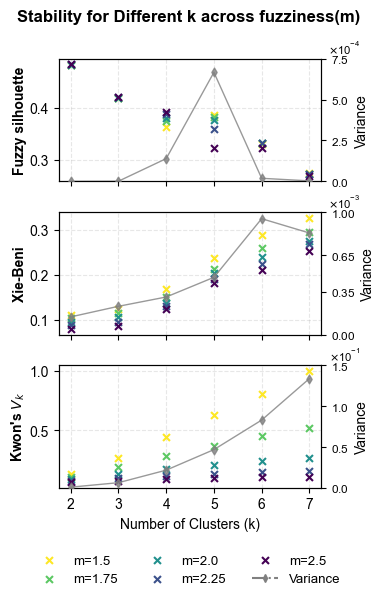

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Read data
history = pd.read_excel('./table/fcm_all_results.xlsx')

# Calculate variance for each k 
var_results = history.groupby('n_clusters')[metrics].var().reset_index()

# Create figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(3.5, 5.5), sharex=True) 
fig.suptitle('Stability for Different k across fuzziness(m)', fontsize=12, fontweight='bold',y=1.02)

# Colors for different fuzziness values
colors = plt.cm.viridis_r(np.linspace(0, 1, len(history['fuzziness'].unique())))
fuzziness_values = sorted(history['fuzziness'].unique())

# Define variance y-limits  
var_y_limits = [(0, 0.00075), (0, 0.0010), (0, 0.15)]
var_y_ticks = [[0, 0.00025, 0.0005, 0.00075],  
               [0, 0.00035, 0.00065, 0.0010],
               [0, 0.05, 0.10, 0.15]] 

# Create subplots for each metric
for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
    ax = axs[idx]

    # Create twin axis for variance 
    ax_var = ax.twinx()

    # Plot performance (left axis)
    for m_idx, m in enumerate(fuzziness_values):
        mask = history['fuzziness'] == m
        ax.scatter(history[mask]['n_clusters'],
                  history[mask][metric],
                  label=f'm={m}',
                  color=colors[m_idx], 
                  s=25, zorder=3, marker='x', alpha=1)

    # Plot variance (right axis)
    ax_var.plot(var_results['n_clusters'], var_results[metric],
                color='grey', linestyle='-', linewidth=1, alpha=0.8,
                label='Variance')  # Added label for variance line
    ax_var.scatter(var_results['n_clusters'], var_results[metric], 
                  color='grey', s=20, zorder=3, alpha=0.8, marker='d')

    # Set labels and grid  
    ax.set_ylabel(f'{label}\n', labelpad=-10, fontweight='bold')
    ax_var.set_ylabel('Variance', color='black')
    ax.grid(True, linestyle='--', alpha=0.3)

    # Set variance axis limits and format with smaller font
    ax_var.set_ylim(var_y_limits[idx]) 
    ax_var.set_yticks(var_y_ticks[idx])
    ax_var.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax_var.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax_var.tick_params(axis='y', labelcolor='black', labelsize=8.5)  # Smaller y-axis font
    
    # Adjust the position and size of scientific notation
    ax_var.yaxis.offsetText.set_position((1.15, 1))
    ax_var.yaxis.offsetText.set_size(8)  # Smaller scientific notation font

    # Set x-ticks  
    ax.set_xticks(sorted(history['n_clusters'].unique()))

# Set x-label for bottom plot
axs[-1].set_xlabel('Number of Clusters (k)')        

# Move legend to bottom with 3 columns and remove frame
handles, labels = axs[0].get_legend_handles_labels()
# Add variance line to legend
handles.append(plt.Line2D([0], [0], color='grey', linestyle='-.', marker='d', markersize=4))
labels.append('Variance')

fig.legend(handles, labels, 
          bbox_to_anchor=(0.5, 0.05),
          loc='upper center',
          ncol=3,
          frameon=False,
          fontsize=9.5)  # Smaller legend font

# Adjust layout 
fig.align_ylabels(axs)
fig.align_ylabels(axs[::-1])
# 增大子图间距
fig.subplots_adjust(hspace=0.25, top=0.93, bottom=0.15, left=0.13, right=0.88)  # 将hspace从0.1增加到0.25

plt.savefig('./image/FCM_clustering_analysis.jpg', dpi=1200, bbox_inches='tight')
plt.show()

## 5.subsample稳定性分析

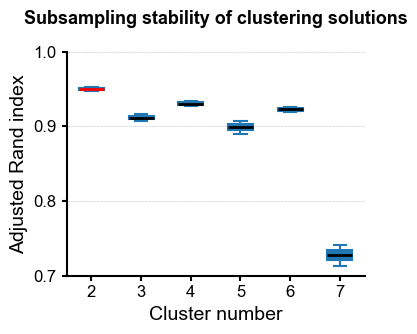

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取最佳结果数据
best_results_df = pd.read_pickle('./pkl/fcm_best_results_df.pkl')

# 提取稳定性相关的列
stability_cols = ['stability_sample_mean', 'stability_ci_lower', 'stability_ci_upper']
stability_data = best_results_df[stability_cols]

# 创建图形和坐标轴
fig, ax = plt.subplots(figsize=(4, 3.5))

# 设置图形样式，参考 Nature 风格
plt.style.use('default')  # 使用默认样式
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['lines.linewidth'] = 2

# 将数据转换为蜡烛图需要的格式
stability_means = stability_data['stability_sample_mean'].values
stability_lowers = stability_data['stability_ci_lower'].values
stability_uppers = stability_data['stability_ci_upper'].values

# 计算箱线图的上下边界和四分位区间
box_data = [list([low, mean, upper]) for low, mean, upper in zip(stability_lowers, stability_means, stability_uppers)]

# 绘制箱线图，调整箱子的宽度，并将Cluster=2的均值线条设置为红色
for i, (low, mean, upper) in enumerate(zip(stability_lowers, stability_means, stability_uppers), start=1):
    # 设置Cluster=2的均值线条为红色
    if i == 1:  # Cluster 2
        median_color = 'red'
    else:
        median_color = 'black'
    
    ax.boxplot([[low, mean, upper]], positions=[i], patch_artist=True, showfliers=False, widths=0.5,
               boxprops=dict(facecolor='#1f77b4', color='#1f77b4', linewidth=1.5),
               whiskerprops=dict(color='#1f77b4', linewidth=1.5),
               medianprops=dict(color=median_color, linewidth=2),
               capprops=dict(color='#1f77b4', linewidth=1.5))

# 设置图形标题和坐标轴标签
ax.set_title('Subsampling stability of clustering solutions', fontsize=13, fontweight='bold', pad=20)
ax.set_xlabel('Cluster number', fontsize=14)
ax.set_ylabel('Adjusted Rand index', fontsize=14)

# 设置x轴刻度
ax.set_xticks(range(1, len(stability_data.index) + 1))
ax.set_xticklabels(stability_data.index, fontsize=12)

# 设置y轴范围
ax.set_ylim(0.70, 1.0)

# 添加水平网格线
ax.grid(axis='y', linestyle='--', linewidth=0.5, color='#cccccc')

# 去除顶部和右侧的边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 调整布局
plt.tight_layout()

# 保存为高分辨率图片
plt.savefig('./image/FCM-stability-Nature.jpg', dpi=1200, bbox_inches='tight', transparent=True)

plt.show()

## 6.输出最佳聚类结果的隶属度和计算label

In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 指定模型路径
model_path = '../../1.FCM/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /pkl/fcm_model_n_clusters_2_fuzziness_2.5.pkl'

# 加载模型
with open(model_path, 'rb') as f_model:
    fcm_model = pickle.load(f_model)

# 1. 打印聚类中心并存储为Excel
centers = fcm_model.centers
print("聚类中心：")
print(centers)

# 将聚类中心存储为Excel文件
centers_df = pd.DataFrame(centers, columns=['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7'])
centers_df.to_excel("./table/fcm_cluster_centers.xlsx", index=False)
print("聚类中心已存储为 fcm_cluster_centers.xlsx")

# 2. 打印超参数组合
print("\n超参数组合：")
fcm_params = {
    'n_clusters': fcm_model.n_clusters,
    'fuzziness': fcm_model.fuzziness,  # 修改了这里
    'max_iter': fcm_model.max_iter,
    'error': fcm_model.error
}
for param, value in fcm_params.items():
    print(f"{param}: {value}")

# 3. 打印隶属度矩阵并存储为Excel
membership_matrix = fcm_model.fcm.u  # 修改了这里,访问 fcm 的 u 属性

# Create an ID column
num_participants = membership_matrix.shape[0]  # Assuming the number of participants is the number of rows in the matrix
ids = [f'{i}' for i in range(num_participants)]

# Convert the membership matrix to a DataFrame and add the ID column
membership_df = pd.DataFrame(membership_matrix, columns=[f'Subtype {i+1}' for i in range(fcm_model.n_clusters)])
membership_df.insert(0, 'ID', ids)  # Insert the ID column at the first position

# Add the 'Group' column based on the conditions
conditions = [
    (membership_df['Subtype 1'] >= 0.60),
    (membership_df['Subtype 2'] >= 0.60),
    ((membership_df['Subtype 1'] < 0.60) & (membership_df['Subtype 2'] < 0.60))
]
choices = [1, 2, 3]
membership_df['Group'] = np.select(conditions, choices)

# Save the DataFrame to an Excel file
membership_df.to_excel("./table/fcm_membership_matrix.xlsx", index=False)

print("隶属度矩阵已存储为 fcm_membership_matrix.xlsx")

聚类中心：
[[-0.44511225  2.02123611 -1.21821567 -0.11950362 -1.33141593 -1.13716758
  -6.60097254]
 [-0.66815174 21.51525452 -1.25074614 -0.13397248 -1.51166523 -1.52398919
  -6.82559652]]
聚类中心已存储为 fcm_cluster_centers.xlsx

超参数组合：
n_clusters: 2
fuzziness: 2.5
max_iter: 1000
error: 1e-05
隶属度矩阵已存储为 fcm_membership_matrix.xlsx


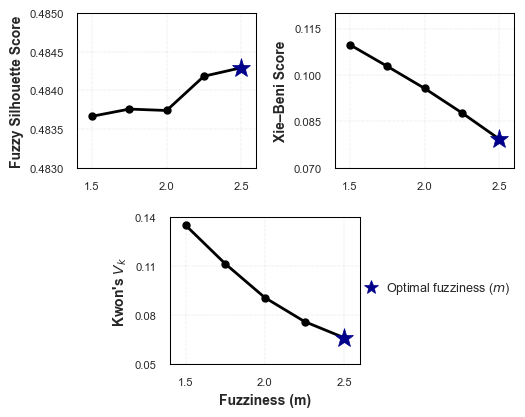

In [13]:
import warnings
from sklearn.base import InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# ========== 全局可视化风格 & 字体设置 ==========
# 学术论文常用字体与统一字号
font_family = 'Arial'
FS_LABEL = 10    # 坐标轴标签字号
FS_TICK = 8      # 刻度标签字号
FS_LEGEND = 9    # 图例字号

sns.set(style="whitegrid")
mpl.rcParams.update({
    'font.family': font_family,
    'axes.labelsize': FS_LABEL,
    'axes.titlesize': FS_LABEL,
    'xtick.labelsize': FS_TICK,
    'ytick.labelsize': FS_TICK,
    'legend.fontsize': FS_LEGEND,
    'axes.titleweight': 'normal',
    'axes.linewidth': 1.25,
    'grid.linewidth': 0.3,
    'grid.color': 'gray',
    'grid.alpha': 0.3
})

# ========== 数据读取 ==========
history = pd.read_excel('./table/fcm_all_results的副本.xlsx')
best_results_df = pd.read_pickle('./pkl/fcm_best_results_df.pkl')
cluster_2_data = history[history['n_clusters'] == 2]

# ========== 绘图参数 ==========
color = 'black'
linestyle = '-'
x_values = np.arange(1.25, 2.75, 0.25)

def mark_best_m(ax, cluster_data, metric, max_metric=True):
    idx = (cluster_data[f'mean_{metric}'].idxmax()
           if max_metric else
           cluster_data[f'mean_{metric}'].idxmin())
    m = cluster_data.loc[idx, 'fuzziness']
    score = cluster_data.loc[idx, f'mean_{metric}']
    ax.plot(m, score,
            marker='*',
            markersize=14,
            color='darkblue',
            markeredgewidth=0.5)

# ========== 创建画布 ==========
fig, axes = plt.subplots(2, 2, figsize=(5.4, 4.2))

# ---------- 子图1：Fuzzy Silhouette Score ----------
ax1 = axes[0, 0]
ax1.plot(cluster_2_data['fuzziness'],
         cluster_2_data['mean_fuzzy_silhouette_score'],
         color=color, linestyle=linestyle, linewidth=2,
         marker='o', markersize=5)
mark_best_m(ax1, cluster_2_data, 'fuzzy_silhouette_score', max_metric=True)
ax1.set_xlim(1.4, 2.6)
ax1.set_xticks([1.5, 2.0, 2.5])
ax1.set_ylim(0.4830, 0.485)
ax1.set_yticks(np.arange(0.4830, 0.4851, 0.0005))
ax1.set_ylabel('Fuzzy Silhouette Score', fontweight='bold')
ax1.grid(which='both', axis='both', linestyle='-.')

# ---------- 子图2：Xie–Beni Score ----------
ax2 = axes[0, 1]
ax2.plot(cluster_2_data['fuzziness'],
         cluster_2_data['mean_xie_beni_score'],
         color=color, linestyle=linestyle, linewidth=2,
         marker='o', markersize=5)
mark_best_m(ax2, cluster_2_data, 'xie_beni_score', max_metric=False)
ax2.set_xlim(1.4, 2.6)
ax2.set_xticks([1.5, 2.0, 2.5])
ax2.set_ylim(0.07, 0.12)
ax2.set_yticks(np.arange(0.07, 0.1201, 0.015))
ax2.set_ylabel('Xie–Beni Score', fontweight='bold')
ax2.grid(which='both', axis='both', linestyle='-.')

# 隐藏底部两个空白画布
axes[1, 0].axis('off')
axes[1, 1].axis('off')

# ---------- 子图3：Kwon’s Vₖ Score（自定义位置） ----------
pos = axes[1, 0].get_position()
new_left = pos.x0 + pos.width * 0.58
new_bottom = pos.y0 - pos.height * 0.11
new_width = pos.width
new_height = pos.height
ax3 = fig.add_axes([new_left, new_bottom, new_width, new_height])

ax3.plot(cluster_2_data['fuzziness'],
         cluster_2_data['mean_kwons_v_k_score'],
         color=color, linestyle=linestyle, linewidth=2,
         marker='o', markersize=5)
mark_best_m(ax3, cluster_2_data, 'kwons_v_k_score', max_metric=False)
ax3.set_xlim(1.4, 2.6)
ax3.set_xticks([1.5, 2.0, 2.5])
ax3.set_yticks(np.arange(0.05, 0.1601, 0.03))
ax3.set_xlabel('Fuzziness (m)', fontweight='bold')
ax3.set_ylabel("Kwon's $V_k$", fontweight='bold')
ax3.grid(which='both', axis='both', linestyle='-.')

# ========== 设置所有子图的外框为黑色 ==========
for ax in [ax1, ax2, ax3]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.75)

# ========== 图例 & 布局 ==========
legend_line = mpl.lines.Line2D(
    [0], [0],
    color='darkblue',
    marker='*',
    linestyle='None',
    markersize=10,
    markeredgewidth=0.5,
    label='Optimal fuzziness ($m$)'
)
fig.legend(
    handles=[legend_line],
    loc='upper center',
    bbox_to_anchor=(0.82, 0.3),
    ncol=1,
     handletextpad=0.2,  
    frameon=False
)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig(
    './image/fcm_nature_style_cluster2_plot.jpg',
    dpi=1200,
    bbox_inches='tight',
    transparent=True
)
plt.show()

## 7.PCA可视化最佳聚类结果分布

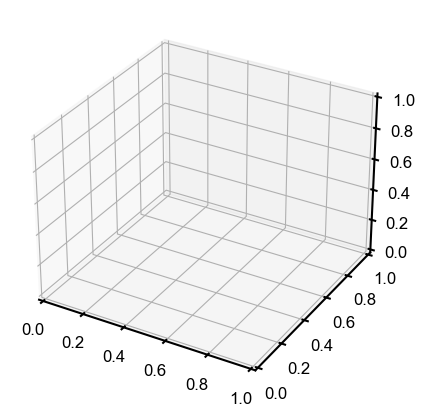

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import seaborn as sns
import pickle
import pandas as pd

# 读取数据
data = pd.read_excel('../../0.数据预处理/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /table/校正并标准化后的患者行为变量数据.xlsx')
EFs_data = data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc', 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

# 读取 fcm_membership_matrix.xlsx 文件并提取 Group、Subtype 1 和 Subtype 2 列
membership_data = pd.read_excel('./table/fcm_membership_matrix.xlsx')
group_data = membership_data['Group']
subtype1_data = membership_data['Subtype 1']
subtype2_data = membership_data['Subtype 2']

# 将 Group、Subtype 1 和 Subtype 2 列添加到原始数据中
data['Group'] = group_data
data['Subtype 1'] = subtype1_data
data['Subtype 2'] = subtype2_data

# 保存更新后的数据到新的 Excel 文件
updated_data_path = '../../0.数据预处理/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /table/updated_data.xlsx'
data.to_excel(updated_data_path, index=False)

palette = sns.color_palette("deep", 8)

# 初始化评估指标字典
best_params_scores = {
    2: {'best_score': 0.75, 'mean_xie_beni_score': 0.12, 'mean_partition_entropy': 0.9},
    3: {'best_score': 0.72, 'mean_xie_beni_score': 0.15, 'mean_partition_entropy': 0.85},
    # 添加其他 n_clusters 的评估数据...
}

# 获取不同聚类数量下的最优模型
best_models = []
for n in range(2, 8):
    with open(f'../../1.FCM/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /pkl/fcm_model_n_clusters_{n}_fuzziness_2.5.pkl', 'rb') as f:
        best_model = pickle.load(f)
        best_models.append(best_model)

# 设置三维图形
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111, projection='3d')

# 遍历最优模型,找到 n_clusters = 2 的模型并进行可视化
for idx, (n_clusters, model) in enumerate(zip(range(2, 8), best_models)):
    if n_clusters == 2:
        # 获取评估指标
        fuzzy_silhouette_score = best_params_scores[n_clusters]['best_score']
        xie_beni_score = best_params_scores[n_clusters]['mean_xie_beni_score']
        partition_entropy = best_params_scores[n_clusters]['mean_partition_entropy']
        
        # 获取聚类中心和标签
        fcm_centers = model.centers
        fcm_labels = model.predict(EFs_data)

        # 可视化代码保持不变

        break  # 只绘制 n_clusters = 2 的模型,绘制完成后退出循环


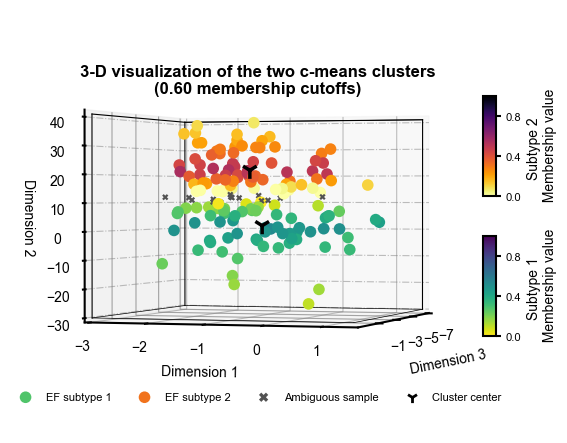

In [66]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import seaborn as sns
import pickle
import pandas as pd
from matplotlib.colorbar import ColorbarBase
# 读取数据
data = pd.read_excel('../../0.数据预处理/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /table/校正并标准化后的患者行为变量数据.xlsx')
EFs_data = data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc', 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

# 读取 fcm_membership_matrix.xlsx 文件并提取 Group、Subtype 1 和 Subtype 2 列
membership_data = pd.read_excel('./table/fcm_membership_matrix.xlsx')
group_data = membership_data['Group']
subtype1_data = membership_data['Subtype 1']
subtype2_data = membership_data['Subtype 2']

# 将 Group、Subtype 1 和 Subtype 2 列添加到原始数据中
data['Group'] = group_data
data['Subtype 1'] = subtype1_data
data['Subtype 2'] = subtype2_data

# 保存更新后的数据到新的 Excel 文件
updated_data_path = '../../0.数据预处理/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /table/updated_data.xlsx'
data.to_excel(updated_data_path, index=False)

palette = sns.color_palette("deep", 8)

# 获取不同聚类数量下的最优模型
best_models = []
for n in range(2, 8):
    with open(f'../../1.FCM/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /pkl/fcm_model_n_clusters_2_fuzziness_2.5.pkl', 'rb') as f:
        best_model = pickle.load(f)
        best_models.append(best_model)

# 设置三维图形
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111, projection='3d')

# 遍历最优模型,找到 n_clusters = 2 的模型并进行可视化
for idx, (n_clusters, model) in enumerate(zip(range(2, 8), best_models)):
    if n_clusters == 2:
        # 获取评估指标
        fuzzy_silhouette_score = best_params_scores[n_clusters]['best_score']
        xie_beni_score = best_params_scores[n_clusters]['mean_xie_beni_score']
        partition_entropy = best_params_scores[n_clusters]['mean_partition_entropy']
        
        # 获取聚类中心和标签
        fcm_centers = model.centers
        fcm_labels = model.predict(EFs_data)

        # 定义 Subtype 1 和 Subtype 2 的颜色映射
        cmap1 = plt.get_cmap('viridis_r')
        cmap2 = plt.get_cmap('inferno_r')

        # 绘制数据点和聚类中心
        for i in range(n_clusters):
            cluster_points = EFs_data.iloc[fcm_labels == i, [2, 0, 1]]  # 调整列的顺序
            
            # 初始化所有数据点的 marker 为 'o'
            markers = ['o'] * len(cluster_points)

            # 根据 Group 和 Subtype 列的值设置数据点的颜色
            colors = []
            sizes = []
            alpha = []
            edgecolors = []  # 新增一个列表来存储数据点的边缘颜色
            for j, (group, subtype1, subtype2) in enumerate(zip(data.loc[fcm_labels == i, 'Group'], data.loc[fcm_labels == i, 'Subtype 1'], data.loc[fcm_labels == i, 'Subtype 2'])):
                if group == 1:
                    colors.append(cmap1(subtype1))
                    sizes.append(70)
                elif group == 2:
                    colors.append(cmap2(subtype2))
                    sizes.append(70)
                elif group == 3:
                    markers[j] = 'X'
                    colors.append('#525252')
                    alpha.append(1.0)
                    edgecolors.append('black')  # 为 group 3 的数据点设置白色边缘
                    sizes.append(20)  # 为 marker 为 'd' 的点设置较小的尺寸
                    
            # 设置 Subtype 1 的颜色映射范围
            # 设置颜色映射的范围
            vmin1 = 0.6  # 自定义的最小值
            vmax1 = 1.3# 自定义的最大值


            # 设置 Subtype 2 的颜色映射范围
            vmin2 = 0.7 # 最小值
            vmax2 = 1.2# 最大值
            
            for j, (marker, point_color, size) in enumerate(zip(markers, colors, sizes)):
                if data.loc[fcm_labels == i, 'Group'].iloc[j] == 1:
                    point_color = cmap1(np.clip((subtype1_data.iloc[fcm_labels == i].iloc[j] - vmin1) / (vmax1 - vmin1), 0, 1))
                elif data.loc[fcm_labels == i, 'Group'].iloc[j] == 2:
                    point_color = cmap2(np.clip((subtype2_data.iloc[fcm_labels == i].iloc[j] - vmin2) / (vmax2 - vmin2), 0, 1))
                
                ax.scatter(cluster_points.iloc[j, 0], cluster_points.iloc[j, 1], cluster_points.iloc[j, 2], alpha=1, label=f'EF subtype {i+1}' if j == 0 else "", color=point_color, edgecolor='none', s=size, marker=marker)

        # 找到位于两个聚类交集处的数据点
        intersection_points = EFs_data.iloc[(fcm_labels == 0) & (fcm_labels == 1), [2, 0, 1]]  # 调整列的顺序
        
        # 绘制位于两个聚类交集处的数据点,并将标记设置为红色方形
        ax.scatter(intersection_points.iloc[:, 0], intersection_points.iloc[:, 1], intersection_points.iloc[:, 2], alpha=1, color='#525252', edgecolor='none', s=45, marker='X', label='Ambiguous sample')
        # 绘制位于两个聚类交集处的数据点,并将标记设置为红色方形
        ax.scatter(intersection_points.iloc[:, 0], intersection_points.iloc[:, 1], intersection_points.iloc[:, 2], alpha=1, color='black', edgecolor='none', s=65, marker='1', label='Cluster center')
        ax.scatter(fcm_centers[:, 2], fcm_centers[:, 0], fcm_centers[:, 1], marker='1', s=150, c='black', linewidths=2.5, alpha=1, zorder=1,edgecolors='white')
        
        # 设置图表标题和标签
        ax.set_title(f'3-D visualization of the two c-means clusters\n(0.60 membership cutoffs)', fontsize=12, fontweight='bold', color='black', y=0.85)
        ax.set_xlabel('Dimension 3', fontsize=10, labelpad=10)
        ax.set_ylabel('Dimension 1', fontsize=10, labelpad=10)
        ax.set_zlabel('Dimension 2', fontsize=10, labelpad=3)
        ax.tick_params(axis='both', which='major', labelsize=10)


        # 创建 Subtype 1 的颜色条
        ax_cbar1 = fig.add_axes([0.75, 0.26, 0.015, 0.2])  # 调整颜色条的位置和大小
        norm1 = plt.Normalize(vmin=0, vmax=1)  # 将颜色条范围设为 0 到 1
        cbar1 = ColorbarBase(ax_cbar1, cmap=cmap1, norm=norm1, orientation='vertical')
        cbar1.set_label('Subtype 1 \n Membership value', fontsize=10)
        cbar1.set_ticks([0, 0.4, 0.8])  # 设置刻度为 0 到 1，步长为 0.4
        cbar1.ax.tick_params(labelsize=8)

        # 创建 Subtype 2 的颜色条
        ax_cbar2 = fig.add_axes([0.75, 0.54, 0.015, 0.2])  # 调整颜色条的位置和大小
        norm2 = plt.Normalize(vmin=0, vmax=1)  # 将颜色条范围设为 0 到 1
        cbar2 = ColorbarBase(ax_cbar2, cmap=cmap2, norm=norm2, orientation='vertical')
        cbar2.set_label('Subtype 2 \n Membership value', fontsize=10)
        cbar2.set_ticks([0, 0.4, 0.8])  # 设置刻度为 0 到 1，步长为 0.4
        cbar2.ax.tick_params(labelsize=8)

        break  # 只绘制 n_clusters = 2 的模型,绘制完成后退出循环


# 设置坐标轴的取值范围和刻度
ax.set_xlim(-7, 1)
ax.set_ylim(-3, 1.5)
ax.set_zlim(-30, 41)
ax.set_xticks(np.arange(-7, 1, 2))
ax.set_yticks(np.arange(-3, 1.5, 1))
ax.set_zticks(np.arange(-30, 41, 10))

# 设置网格线的颜色和粗细
ax.xaxis._axinfo["grid"]['color'] = (0.5, 0.5, 0.5, 0.7)
ax.yaxis._axinfo["grid"]['color'] = (0.5, 0.5, 0.5, 0.5)
ax.zaxis._axinfo["grid"]['color'] = (0.5, 0.5, 0.5, 0.5)
ax.xaxis._axinfo["grid"]['linestyle'] = '-'
ax.yaxis._axinfo["grid"]['linestyle'] = '-'
ax.zaxis._axinfo["grid"]['linestyle'] = '-.'
ax.xaxis._axinfo["grid"]['linewidth'] = 0.8
ax.yaxis._axinfo["grid"]['linewidth'] = 0.8
ax.zaxis._axinfo["grid"]['linewidth'] = 0.8

# 调整图例位置
ax.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5,0.12), ncol=4, frameon=False)

# 调整布局以获得更好的间距
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整 rect 值以控制边距

# 调整视角
ax.view_init(elev=0.5, azim=18)  # 仰角为 20 度,方位角为 45 度

# 在另一侧添加一条线表示 Y 轴,但没有坐标和标注
y_min, y_max = ax.get_ylim()
z_min, z_max = ax.get_zlim()
x_max, x_min = ax.get_xlim()
ax.plot([x_max, x_max], [y_min, y_max], [z_max, z_max], 'k-', linewidth=0.5, color='black')

# 获取 x, y, z 轴的最小和最大值
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
z_min, z_max = ax.get_zlim()

# 定义立方体的顶点坐标
vertices = np.array([
    [x_min, y_min, z_min],
    [x_max, y_min, z_min],
    [x_max, y_max, z_min],
    [x_min, y_max, z_min],
    [x_min, y_min, z_max],
    [x_max, y_min, z_max],
    [x_max, y_max, z_max],
    [x_min, y_max, z_max]
])

# 定义立方体的面
faces = [
    [vertices[0], vertices[1], vertices[2], vertices[3]],  # 底面
    [vertices[4], vertices[5], vertices[6], vertices[7]],  # 顶面
    [vertices[0], vertices[1], vertices[5], vertices[4]],  # 前面
    [vertices[2], vertices[3], vertices[7], vertices[6]],  # 后面
    [vertices[1], vertices[2], vertices[6], vertices[5]],  # 右侧面
    [vertices[4], vertices[7], vertices[3], vertices[0]]   # 左侧面
]

# 绘制立方体的棱
for i in range(4):
    # 绘制底面的棱
    ax.plot(
        [vertices[i,0], vertices[(i+1)%4,0]],           # 棱的起点和终点的 x 坐标
        [vertices[i,1], vertices[(i+1)%4,1]],           # 棱的起点和终点的 y 坐标
        [vertices[i,2], vertices[(i+1)%4,2]],           # 棱的起点和终点的 z 坐标
        'black',                                        # 棱的颜色
        linewidth=0.5                                     # 棱的线宽
    )
    

    if i not in [1, 2]:  # 不绘制右侧面和后侧面的顶棱
        ax.plot(
            [vertices[i+4,0], vertices[(i+1)%4+4,0]],       # 棱的起点和终点的 x 坐标
            [vertices[i+4,1], vertices[(i+1)%4+4,1]],       # 棱的起点和终点的 y 坐标
            [vertices[i+4,2], vertices[(i+1)%4+4,2]],       # 棱的起点和终点的 z 坐标
            'black',                                        # 棱的颜色
            linewidth=0.8                                    # 棱的线宽
        )

    # 绘制连接顶面和底面的竖棱
    if i != 2:  # 不绘制右侧面的竖棱
        ax.plot(
            [vertices[i,0], vertices[i+4,0]],               # 棱的起点和终点的 x 坐标
            [vertices[i,1], vertices[i+4,1]],               # 棱的起点和终点的 y 坐标
            [vertices[i,2], vertices[i+4,2]],               # 棱的起点和终点的 z 坐标
            'black',                                        # 棱的颜色
            linewidth=0.8                                   # 棱的线宽
        )
        
# 保存为高分辨率图像
plt.savefig('./image/FCM聚类可视化_Cluster2baseline sample_3D_with_hyperplane_axis_swapped_bold_edges.jpg', dpi=1200, bbox_inches='tight')
plt.show()

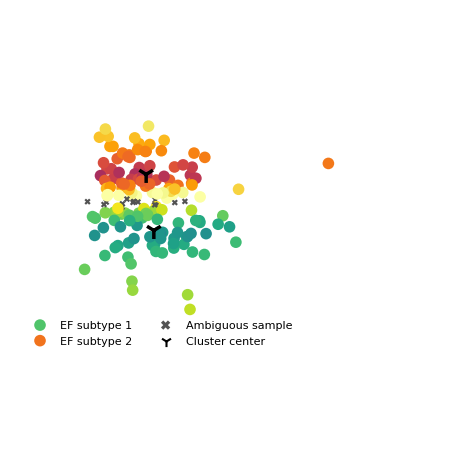

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import seaborn as sns
import pickle
import pandas as pd

# 读取数据
data = pd.read_excel('../../0.数据预处理/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /table/校正并标准化后的患者行为变量数据.xlsx')
EFs_data = data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc', 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

# 读取 fcm_membership_matrix.xlsx 文件并提取 Group、Subtype 1 和 Subtype 2 列
membership_data = pd.read_excel('./table/fcm_membership_matrix.xlsx')
group_data = membership_data['Group']
subtype1_data = membership_data['Subtype 1']
subtype2_data = membership_data['Subtype 2']

# 将 Group、Subtype 1 和 Subtype 2 列添加到原始数据中
data['Group'] = group_data
data['Subtype 1'] = subtype1_data
data['Subtype 2'] = subtype2_data

# 保存更新后的数据到新的 Excel 文件
updated_data_path = '../../0.数据预处理/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /table/updated_data.xlsx'
data.to_excel(updated_data_path, index=False)

palette = sns.color_palette("deep", 8)

# 获取不同聚类数量下的最优模型
best_models = []
for n in range(2, 8):
    with open(f'../../1.FCM/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /pkl/fcm_model_n_clusters_2_fuzziness_2.5.pkl', 'rb') as f:
        best_model = pickle.load(f)
        best_models.append(best_model)

# 设置三维图形
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111, projection='3d')

# 遍历最优模型,找到 n_clusters = 2 的模型并进行可视化
for idx, (n_clusters, model) in enumerate(zip(range(2, 8), best_models)):
    if n_clusters == 2:
        # 获取评估指标
        fuzzy_silhouette_score = best_params_scores[n_clusters]['best_score']
        xie_beni_score = best_params_scores[n_clusters]['mean_xie_beni_score']
        partition_entropy = best_params_scores[n_clusters]['mean_partition_entropy']
        
        # 获取聚类中心和标签  
        fcm_centers = model.centers
        fcm_labels = model.predict(EFs_data)

        # 定义 Subtype 1 和 Subtype 2 的颜色映射
        cmap1 = plt.get_cmap('viridis_r')
        cmap2 = plt.get_cmap('inferno_r')

        # 绘制数据点和聚类中心
        for i in range(n_clusters):
            cluster_points = EFs_data.iloc[fcm_labels == i, [2, 0, 1]]  # 调整列的顺序
            
            # 初始化所有数据点的 marker 为 'o'
            markers = ['o'] * len(cluster_points)

            # 根据 Group 和 Subtype 列的值设置数据点的颜色
            colors = []
            sizes = []
            alpha = []
            edgecolors = []  # 新增一个列表来存储数据点的边缘颜色
            for j, (group, subtype1, subtype2) in enumerate(zip(data.loc[fcm_labels == i, 'Group'], data.loc[fcm_labels == i, 'Subtype 1'], data.loc[fcm_labels == i, 'Subtype 2'])):
                if group == 1:
                    colors.append(cmap1(subtype1))
                    sizes.append(70)
                elif group == 2:
                    colors.append(cmap2(subtype2))
                    sizes.append(70)
                elif group == 3:
                    markers[j] = 'X'
                    colors.append('#525252')
                    alpha.append(1.0)
                    edgecolors.append('black')  # 为 group 3 的数据点设置白色边缘
                    sizes.append(20)  # 为 marker 为 'd' 的点设置较小的尺寸
                    
            # 设置 Subtype 1 的颜色映射范围
            # 设置颜色映射的范围
            vmin1 = 0.6  # 自定义的最小值
            vmax1 = 1.3# 自定义的最大值


            # 设置 Subtype 2 的颜色映射范围
            vmin2 = 0.7 # 最小值
            vmax2 = 1.2# 最大值
            
            for j, (marker, point_color, size) in enumerate(zip(markers, colors, sizes)):
                if data.loc[fcm_labels == i, 'Group'].iloc[j] == 1:
                    point_color = cmap1(np.clip((subtype1_data.iloc[fcm_labels == i].iloc[j] - vmin1) / (vmax1 - vmin1), 0, 1))
                elif data.loc[fcm_labels == i, 'Group'].iloc[j] == 2:
                    point_color = cmap2(np.clip((subtype2_data.iloc[fcm_labels == i].iloc[j] - vmin2) / (vmax2 - vmin2), 0, 1))
                
                ax.scatter(cluster_points.iloc[j, 0], cluster_points.iloc[j, 1], cluster_points.iloc[j, 2], alpha=1, label=f'EF subtype {i+1}' if j == 0 else "", color=point_color, edgecolor='none', s=size, marker=marker)

        # 找到位于两个聚类交集处的数据点
        intersection_points = EFs_data.iloc[(fcm_labels == 0) & (fcm_labels == 1), [2, 0, 1]]  # 调整列的顺序
        
        # 绘制位于两个聚类交集处的数据点,并将标记设置为红色方形
        ax.scatter(intersection_points.iloc[:, 0], intersection_points.iloc[:, 1], intersection_points.iloc[:, 2], alpha=1, color='#525252', edgecolor='none', s=45, marker='X', label='Ambiguous sample')
        # 绘制位于两个聚类交集处的数据点,并将标记设置为红色方形
        ax.scatter(intersection_points.iloc[:, 0], intersection_points.iloc[:, 1], intersection_points.iloc[:, 2], alpha=1, color='black', edgecolor='none', s=65, marker='1', label='Cluster center')
        ax.scatter(fcm_centers[:, 2], fcm_centers[:, 0], fcm_centers[:, 1], marker='1', s=150, c='black', linewidths=2.5, alpha=1, zorder=1,edgecolors='white')
        
        break  # 只绘制 n_clusters = 2 的模型,绘制完成后退出循环

# 去掉坐标轴和刻度
ax.set_axis_off()

# 调整图例位置
ax.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.35,0.3), ncol=2, frameon=False)

# 调整布局以获得更好的间距
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整 rect 值以控制边距

# 调整视角
ax.view_init(elev=0.5, azim=18)  # 仰角为 20 度,方位角为 45 度

# 保存为高分辨率图像
plt.savefig('./image/FCM聚类可视化_Cluster2baseline sample_3D_no_axes_legend_only.jpg', dpi=2000, bbox_inches='tight')
plt.show()

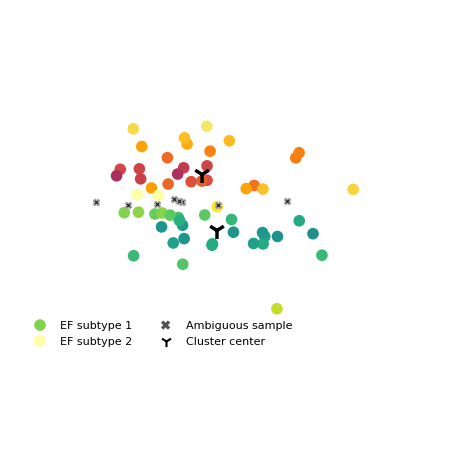

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import seaborn as sns
import pickle
import pandas as pd

# 读取数据
data = pd.read_excel(
    '../../0.数据预处理/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /table/校正并标准化后的患者行为变量数据.xlsx'
)
EFs_data = data[[
    'Stroop_incongruent_rt',
    'Stroop_interference effect_rt',
    'Nogo_acc',
    'Switch_cost',
    'RM-1,750_acc',
    'RM-750_acc',
    'DSBT_Span'
]]

# 读取 fcm_membership_matrix.xlsx 文件并提取 Group、Subtype 1 和 Subtype 2 列
membership_data = pd.read_excel('./table/fcm_membership_matrix.xlsx')
group_data = membership_data['Group']
subtype1_data = membership_data['Subtype 1']
subtype2_data = membership_data['Subtype 2']

# 将 Group、Subtype 1 和 Subtype 2 列添加到原始数据中
data['Group'] = group_data
data['Subtype 1'] = subtype1_data
data['Subtype 2'] = subtype2_data

# 保存更新后的数据到新的 Excel 文件
updated_data_path = (
    '../../0.数据预处理/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 '
    '/table/updated_data.xlsx'
)
data.to_excel(updated_data_path, index=False)

# 为了减少三分之一的数据点用于可视化，随机抽取2/3的样本
np.random.seed(2024)
total_points = len(EFs_data)
sample_size = int(total_points * 2 / 5)
selected_idx = np.random.choice(total_points, size=sample_size, replace=False)

palette = sns.color_palette("deep", 8)

# 获取不同聚类数量下的最优模型
best_models = []
for n in range(2, 8):
    with open(
        f'../../1.FCM/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 '
        f'/pkl/fcm_model_n_clusters_2_fuzziness_2.5.pkl', 'rb'
    ) as f:
        best_model = pickle.load(f)
        best_models.append(best_model)

# 设置三维图形
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111, projection='3d')

# 遍历最优模型, 找到 n_clusters = 2 的模型并进行可视化
for idx, (n_clusters, model) in enumerate(zip(range(2, 8), best_models)):
    if n_clusters == 2:
        # 获取评估指标
        fuzzy_silhouette_score = best_params_scores[n_clusters]['best_score']
        xie_beni_score = best_params_scores[n_clusters]['mean_xie_beni_score']
        partition_entropy = best_params_scores[n_clusters]['mean_partition_entropy']

        # 获取聚类中心和标签  
        fcm_centers = model.centers
        fcm_labels = model.predict(EFs_data)

        # 定义 Subtype 1 和 Subtype 2 的颜色映射
        cmap1 = plt.get_cmap('viridis_r')
        cmap2 = plt.get_cmap('inferno_r')

        # 设置颜色映射的范围
        vmin1, vmax1 = 0.6, 1.3
        vmin2, vmax2 = 0.7, 1.2

        # 遍历每个子类型，按抽样索引绘制数据点
        for i in range(n_clusters):
            # 找到属于第 i 个聚类的所有索引，并与抽样索引取交集
            cluster_idx = np.where(fcm_labels == i)[0]
            displayed_idx = np.intersect1d(cluster_idx, selected_idx)
            # 提取抽样后的聚类点坐标，调整列顺序
            cluster_points = EFs_data.iloc[displayed_idx, [2, 0, 1]]

            # 为每个抽样点绘制
            for j, data_idx in enumerate(displayed_idx):
                group = data.loc[data_idx, 'Group']
                marker = 'o'
                size = 70
                edgecolor = 'none'

                if group == 1:
                    color = cmap1(
                        np.clip((data.loc[data_idx, 'Subtype 1'] - vmin1) / (vmax1 - vmin1), 0, 1)
                    )
                elif group == 2:
                    color = cmap2(
                        np.clip((data.loc[data_idx, 'Subtype 2'] - vmin2) / (vmax2 - vmin2), 0, 1)
                    )
                else:  # group == 3
                    marker = 'X'
                    color = 'black'
                    size = 20
                    edgecolor = 'darkgrey'

                ax.scatter(
                    cluster_points.iloc[j, 0],
                    cluster_points.iloc[j, 1],
                    cluster_points.iloc[j, 2],
                    alpha=1,
                    label=f'EF subtype {i+1}' if j == 0 else "",
                    color=color,
                    edgecolor=edgecolor,
                    s=size,
                    marker=marker
                )

        # 找到位于两个聚类交集处的数据点（此处逻辑与原始一致）
        intersection_points = EFs_data.iloc[
            (fcm_labels == 0) & (fcm_labels == 1), [2, 0, 1]
        ]
        ax.scatter(
            intersection_points.iloc[:, 0],
            intersection_points.iloc[:, 1],
            intersection_points.iloc[:, 2],
            alpha=1,
            color='#525252',
            edgecolor='none',
            s=45,
            marker='X',
            label='Ambiguous sample'
        )
        ax.scatter(
            intersection_points.iloc[:, 0],
            intersection_points.iloc[:, 1],
            intersection_points.iloc[:, 2],
            alpha=1,
            color='black',
            edgecolor='none',
            s=65,
            marker='1',
            label='Cluster center'
        )
        ax.scatter(
            fcm_centers[:, 2],
            fcm_centers[:, 0],
            fcm_centers[:, 1],
            marker='1',
            s=150,
            c='black',
            linewidths=2.5,
            alpha=1,
            zorder=1,
            edgecolors='white'
        )

        break  # 只绘制 n_clusters = 2 的模型，绘制完成后退出循环

# 去掉坐标轴和刻度
ax.set_axis_off()

# 调整图例位置
ax.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.35, 0.3), ncol=2, frameon=False)

# 调整布局以获得更好的间距
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 调整视角
ax.view_init(elev=0.5, azim=18)

# 保存为高分辨率图像
plt.savefig(
    './image/FCM聚类可视化_Cluster2baseline sample_3D_no_axes_legend_only.jpg',
    dpi=2000,
    bbox_inches='tight'
)
plt.show()

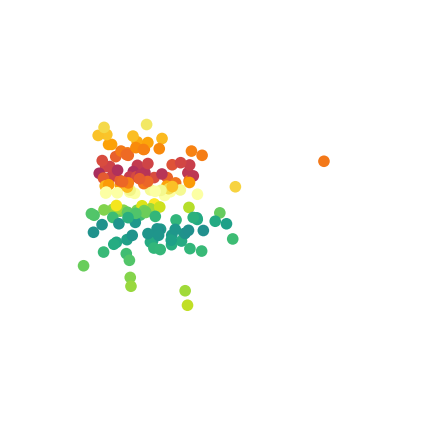

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import seaborn as sns
import pickle
import pandas as pd

# 读取数据
data = pd.read_excel('../../4.基线数据分析-想要得到理想结果/2.聚类分析/0.数据预处理/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /table/校正并标准化后的患者行为变量数据.xlsx')
EFs_data = data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc', 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

# 读取 fcm_membership_matrix.xlsx 文件并提取 Group、Subtype 1 和 Subtype 2 列
membership_data = pd.read_excel('./table/fcm_membership_matrix.xlsx')
group_data = membership_data['Group']
subtype1_data = membership_data['Subtype 1']
subtype2_data = membership_data['Subtype 2']

# 将 Group、Subtype 1 和 Subtype 2 列添加到原始数据中
data['Group'] = group_data
data['Subtype 1'] = subtype1_data
data['Subtype 2'] = subtype2_data

# 保存更新后的数据到新的 Excel 文件
updated_data_path = '../../4.基线数据分析-想要得到理想结果/2.聚类分析/0.数据预处理/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /table/updated_data.xlsx'
data.to_excel(updated_data_path, index=False)

palette = sns.color_palette("deep", 8)

# 获取不同聚类数量下的最优模型
best_models = []
for n in range(2, 8):
    with open(f'../../4.基线数据分析-想要得到理想结果/2.聚类分析/1.FCM/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /pkl/fcm_model_n_clusters_2_fuzziness_2.5.pkl', 'rb') as f:
        best_model = pickle.load(f)
        best_models.append(best_model)

# 设置三维图形
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111, projection='3d')

# 遍历最优模型,找到 n_clusters = 2 的模型并进行可视化
for idx, (n_clusters, model) in enumerate(zip(range(2, 8), best_models)):
    if n_clusters == 2:
        # 获取评估指标
        fuzzy_silhouette_score = best_params_scores[n_clusters]['best_score']
        xie_beni_score = best_params_scores[n_clusters]['mean_xie_beni_score']
        partition_entropy = best_params_scores[n_clusters]['mean_partition_entropy']
        
        # 获取聚类中心和标签  
        fcm_centers = model.centers
        fcm_labels = model.predict(EFs_data)

        # 定义 Subtype 1 和 Subtype 2 的颜色映射
        cmap1 = plt.get_cmap('viridis_r')
        cmap2 = plt.get_cmap('inferno_r')

        # 绘制数据点和聚类中心
        for i in range(n_clusters):
            cluster_points = EFs_data.iloc[fcm_labels == i, [2, 0, 1]]  # 调整列的顺序
            
            # 初始化所有数据点的 marker 为 'o'
            markers = ['o'] * len(cluster_points)

            # 根据 Group 和 Subtype 列的值设置数据点的颜色
            colors = []
            sizes = []
            alpha = []
            edgecolors = []  # 新增一个列表来存储数据点的边缘颜色
            for j, (group, subtype1, subtype2) in enumerate(zip(data.loc[fcm_labels == i, 'Group'], data.loc[fcm_labels == i, 'Subtype 1'], data.loc[fcm_labels == i, 'Subtype 2'])):
                if group == 1:
                    colors.append(cmap1(subtype1))
                    sizes.append(70)
                elif group == 2:
                    colors.append(cmap2(subtype2))
                    sizes.append(70)
                elif group == 3:
                    markers[j] = 'X'
                    colors.append('none')
                    alpha.append(1.0)
                    edgecolors.append('none')  # 为 group 3 的数据点设置白色边缘
                    sizes.append(1)  # 为 marker 为 'd' 的点设置较小的尺寸
                    
            # 设置 Subtype 1 的颜色映射范围
            # 设置颜色映射的范围
            vmin1 = 0.6  # 自定义的最小值
            vmax1 = 1.3# 自定义的最大值


            # 设置 Subtype 2 的颜色映射范围
            vmin2 = 0.7 # 最小值
            vmax2 = 1.2# 最大值
            
            for j, (marker, point_color, size) in enumerate(zip(markers, colors, sizes)):
                if data.loc[fcm_labels == i, 'Group'].iloc[j] == 1:
                    point_color = cmap1(np.clip((subtype1_data.iloc[fcm_labels == i].iloc[j] - vmin1) / (vmax1 - vmin1), 0, 1))
                elif data.loc[fcm_labels == i, 'Group'].iloc[j] == 2:
                    point_color = cmap2(np.clip((subtype2_data.iloc[fcm_labels == i].iloc[j] - vmin2) / (vmax2 - vmin2), 0, 1))
                
                ax.scatter(cluster_points.iloc[j, 0], cluster_points.iloc[j, 1], cluster_points.iloc[j, 2], alpha=1, label=f'EF subtype {i+1}' if j == 0 else "", color=point_color, edgecolor='none', s=size, marker=marker)

        # 找到位于两个聚类交集处的数据点
        intersection_points = EFs_data.iloc[(fcm_labels == 0) & (fcm_labels == 1), [2, 0, 1]]  # 调整列的顺序
        
        # 绘制位于两个聚类交集处的数据点,并将标记设置为红色方形
        ax.scatter(intersection_points.iloc[:, 0], intersection_points.iloc[:, 1], intersection_points.iloc[:, 2], alpha=1, color='#525252', edgecolor='none', s=45, marker='X', label='Ambiguous sample')
        # 绘制位于两个聚类交集处的数据点,并将标记设置为红色方形
        ax.scatter(intersection_points.iloc[:, 0], intersection_points.iloc[:, 1], intersection_points.iloc[:, 2], alpha=1, color='black', edgecolor='none', s=65, marker='1', label='Cluster center')
        ax.scatter(fcm_centers[:, 2], fcm_centers[:, 0], fcm_centers[:, 1], marker='1', s=150, c='none', linewidths=2.5, alpha=1, zorder=1,edgecolors='white')
        
        break  # 只绘制 n_clusters = 2 的模型,绘制完成后退出循环

# 去掉坐标轴和刻度
ax.set_axis_off()

# 调整布局以获得更好的间距
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整 rect 值以控制边距

# 调整视角
ax.view_init(elev=0.5, azim=18)  # 仰角为 20 度,方位角为 45 度

# 保存为高分辨率图像
plt.savefig('./image/FCM聚类可视化_Cluster2baseline sample_3D_no_axes_legend_only222.jpg', dpi=2000, bbox_inches='tight')
plt.show()

## 9.随访稳定性检验

In [4]:
import pandas as pd
import numpy as np
import pickle
from scipy.spatial.distance import cdist

# 读取随访样本数据
followup_data = pd.read_excel('/Users/zhangtongyi/Desktop/A1论文的数据文档/P0022024-认知聚类-project(最新版）/1.当前最新版本 /3.基线数据分析/2.聚类分析/0.数据预处理/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 （随访数据）/table/校正并标准化后的患者行为变量数据.xlsx',
    sheet_name='Sheet1'  # 指定读取的工作表名称
)
followup_EFs_data = followup_data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc', 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

# 加载最佳的FCM模型
with open(f'../../1.FCM/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /pkl/fcm_model_n_clusters_2_fuzziness_2.0.pkl', 'rb') as f:
    best_fcm_model = pickle.load(f)

# 获取基线样本的聚类中心
cluster_centers = best_fcm_model.centers

# 计算每个随访患者与基线样本聚类中心的欧式距离
distances = cdist(followup_EFs_data.values, cluster_centers, metric='euclidean')

# 设置模糊度控制参数 m
fuzziness = 1.5

# 计算每个随访患者的隶属度值
followup_membership = 1 / (2 + distances ** (1.5 / (fuzziness )))
followup_membership /= followup_membership.sum(axis=1, keepdims=True)

# 创建一个DataFrame来存储随访样本的隶属度值和距离
followup_membership_df = pd.DataFrame(followup_membership, columns=[f'Cluster {i+1} Membership' for i in range(best_fcm_model.n_clusters)])
followup_membership_df = pd.concat([followup_membership_df, pd.DataFrame(distances, columns=[f'Cluster {i+1} Distance' for i in range(best_fcm_model.n_clusters)])], axis=1)

# 保存随访样本的隶属度值和距离
followup_membership_df.to_excel('./table/随访样本隶属度和距离_euclidean_2.5.xlsx', index=False)
print('随访样本的隶属度值和距离已保存到 "随访样本隶属度和距离_euclidean_2.5.xlsx" 文件中。')

随访样本的隶属度值和距离已保存到 "随访样本隶属度和距离_euclidean_2.5.xlsx" 文件中。


## 10.随访（纵向,4~6weeks）稳定性分析

/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_10769/2989403785.py:108: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=0.2)


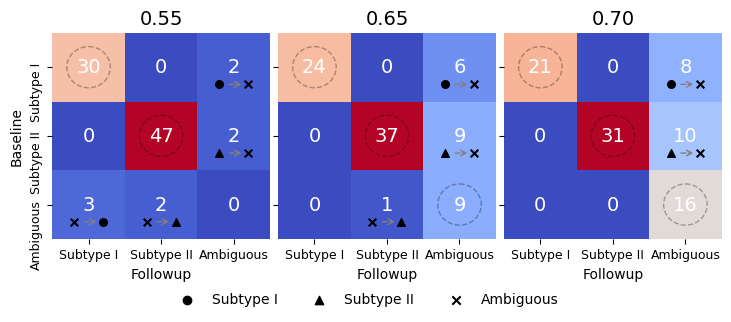

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, Patch, FancyArrow

# 读取数据
data = pd.read_excel('../../1.FCM/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /0.65和0.70稳定性.xlsx')

# 定义函数来计算每个值的变化人数
def calculate_transitions(baseline_col, followup_col):
    transition_counts = pd.crosstab(data[baseline_col], data[followup_col], rownames=['Baseline'], colnames=['Followup'])
    return transition_counts

# 创建一个函数来绘制热图并手动添加注释
def plot_transition_heatmap(transitions, title, ax, labels, cmap):
    sns.heatmap(transitions, annot=True, fmt='d', cmap=cmap, cbar=False, 
                annot_kws={"color": "white", "fontsize": 14}, ax=ax)
    ax.set_title(title, fontsize=14)
    
    # 替换轴标签并设置字体大小和加粗
    ax.set_xticklabels([labels.get(int(label.get_text()), label.get_text()) for label in ax.get_xticklabels()], fontsize=9)
    ax.set_yticklabels([labels.get(int(label.get_text()), label.get_text()) for label in ax.get_yticklabels()], fontsize=9)

    # 手动添加第二行和第三行的注释
    rows_to_annotate = [1, 2]  # 第二行和第三行
    cols_to_annotate = [0, 1, 2]  # 第一列、第二列和第三列
    for row in rows_to_annotate:
        for col in cols_to_annotate:
            value = transitions.iloc[row, col]
            ax.text(col + 0.5, row + 0.5, f'{value}', color='white', ha='center', va='center', fontsize=14)

    # 标出Baseline和Follow-up人数相等的单元格
    for row in range(transitions.shape[0]):
        for col in range(transitions.shape[1]):
            if transitions.index[row] == transitions.columns[col] and transitions.iloc[row, col] > 0:
                circle = Circle((col + 0.5, row + 0.5), 0.3, color='black', fill=False, linewidth=1, alpha=0.3, linestyle='--')
                ax.add_patch(circle)

            # 添加基线到随访的转变符号
            if transitions.index[row] != transitions.columns[col] and transitions.iloc[row, col] > 0:
                # 基线标记符号
                if transitions.index[row] == 0:  
                    marker_baseline = 'o'  
                elif transitions.index[row] == 1:  
                    marker_baseline = '^'  
                else:  
                    marker_baseline = 'x'  

                # 随访标记符号
                if transitions.columns[col] == 0:  
                    marker_followup = 'o'  
                elif transitions.columns[col] == 1:  
                    marker_followup = '^'  
                    color_followup = 'orange'
                else:  
                    marker_followup = 'x'  
                    color_followup = 'orange'

                # 调整箭头参数
                arrow_length = 0.1
                arrow_vertical_offset = 0.25

                # 绘制基线符号
                ax.scatter(col + 0.3, row + 0.5 + arrow_vertical_offset, marker=marker_baseline, color='black', s=30)

                # 添加带虚线的箭头
                ax.annotate('', 
                            xy=(col + 0.65, row + 0.5 + arrow_vertical_offset),
                            xytext=(col + 0.4, row + 0.5 + arrow_vertical_offset),
                            arrowprops=dict(arrowstyle='->', linestyle='--', color='grey', lw=1))

                # 绘制随访符号
                ax.scatter(col + 0.7, row + 0.5 + arrow_vertical_offset, marker=marker_followup, color='black', s=30)

# 定义标签
labels = {0: 'Subtype I', 1: 'Subtype II', 3: 'Ambiguous'}

# 修改列名列表，只保留三个阈值
baseline_cols = ['baseline0.55', 'baseline0.65', 'baseline0.70']
followup_cols = ['followup0.55', 'followup0.65', 'followup0.70']

# 创建单行三列的子图布局
fig, axes = plt.subplots(1, 3, figsize=(7.2, 2.8), constrained_layout=True)

# 计算并绘制各阈值的变化热图
titles = ['0.55', '0.65', '0.70']
cmap = "coolwarm"

for i, (baseline_col, followup_col, title) in enumerate(zip(baseline_cols, followup_cols, titles)):
    transitions = calculate_transitions(baseline_col, followup_col)
    plot_transition_heatmap(transitions, title, axes[i], labels, cmap)
    
    # 非左侧的图不显示Y轴标签
    if i > 0:
        axes[i].set_ylabel('')
        axes[i].set_yticklabels([])

# 添加图例
legend_elements = [
    plt.scatter([], [], marker='o', color='black', label='Subtype I'),
    plt.scatter([], [], marker='^', color='black', label='Subtype II'),
    plt.scatter([], [], marker='x', color='black', label='Ambiguous'),
]

fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10, borderaxespad=0.5, bbox_to_anchor=(0.5, -0.12),frameon=False)

# 调整子图间距，给图例留出空间
plt.subplots_adjust(bottom=0.2)


plt.savefig('./image/transition_heatmaps_with_arrows.jpg', dpi=1200, bbox_inches='tight')
plt.show()

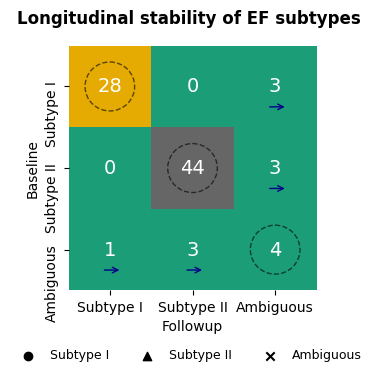

Transitions for 0.60 Threshold:
Followup   0   1  3
Baseline           
0         28   0  3
1          0  44  3
3          1   3  4


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, Patch, FancyArrow

# 读取数据
data = pd.read_excel('../../1.FCM/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /0.65和0.70稳定性.xlsx')

# 定义函数来计算每个值的变化人数
def calculate_transitions(baseline_col, followup_col):
    transition_counts = pd.crosstab(data[baseline_col], data[followup_col], rownames=['Baseline'], colnames=['Followup'])
    return transition_counts

# 创建一个函数来绘制热图并手动添加注释
def plot_transition_heatmap(transitions, title, ax, labels, cmap):
    sns.heatmap(transitions, annot=True, fmt='d', cmap=cmap, cbar=False, 
                annot_kws={"color": "white", "fontsize": 14}, ax=ax)
    ax.set_title(title, fontsize=14)
    
    # 替换轴标签并设置字体大小和加粗
    ax.set_xticklabels([labels.get(int(label.get_text()), label.get_text()) for label in ax.get_xticklabels()], fontsize=10)
    ax.set_yticklabels([labels.get(int(label.get_text()), label.get_text()) for label in ax.get_yticklabels()], fontsize=10)

    # 手动添加第二行和第三行的注释
    rows_to_annotate = [1, 2]  # 第二行和第三行
    cols_to_annotate = [0, 1, 2]  # 第一列、第二列和第三列
    for row in rows_to_annotate:
        for col in cols_to_annotate:
            value = transitions.iloc[row, col]
            ax.text(col + 0.5, row + 0.5, f'{value}', color='white', ha='center', va='center', fontsize=14)

    # 标出Baseline和Follow-up人数相等的单元格
    for row in range(transitions.shape[0]):
        for col in range(transitions.shape[1]):
            if transitions.index[row] == transitions.columns[col] and transitions.iloc[row, col] > 0:
                circle = Circle((col + 0.5, row + 0.5), 0.3, color='black', fill=False, linewidth=1, alpha=0.6, linestyle='--')
                ax.add_patch(circle)

            # 添加基线到随访的转变符号 (基线符号 + 箭头 + 随访符号)
            if transitions.index[row] != transitions.columns[col] and transitions.iloc[row, col] > 0:
                # 基线标记符号
                if transitions.index[row] == 0:  # Subtype I
                    marker_baseline = 'o'  # 方形
                elif transitions.index[row] == 1:  # Subtype II
                    marker_baseline = '^'  # 星形
                else:  # Mixed
                    marker_baseline = 'x'  # X形

                # 随访标记符号
                if transitions.columns[col] == 0:  # Subtype I
                    marker_followup = 'o'  # 方形
                elif transitions.columns[col] == 1:  # Subtype II
                    marker_followup = '^'  # 星形
                    color_followup = 'orange'
                else:  # Mixed
                    marker_followup = 'x'  # X形
                    color_followup = 'orange'

                # 调整箭头长度和上下位置的参数
                arrow_length = 0.1  # 调整箭头长度
                arrow_vertical_offset = 0.25  # 调整箭头的上下偏移量

                # 绘制基线符号
                ax.scatter(col + 0.3, row + 0.5 + arrow_vertical_offset, marker=marker_baseline, color='black', s=0)

                # 添加带虚线的箭头，缩短箭头长度
                ax.annotate('', 
                            xy=(col + 0.65, row + 0.5 + arrow_vertical_offset),  # 缩短后的箭头终点
                            xytext=(col + 0.4, row + 0.5 + arrow_vertical_offset),  # 箭头起点
                            arrowprops=dict(arrowstyle='->', linestyle='-', color='darkblue', lw=1))  # 虚线和箭头样式

                # 绘制随访符号
                ax.scatter(col + 0.7, row + 0.5 + arrow_vertical_offset, marker=marker_followup, color='black', s=0)

# 定义标签
labels = {0: 'Subtype I', 1: 'Subtype II', 3: 'Ambiguous'}

# 创建单个图表
fig, ax = plt.subplots(figsize=(3.2, 3.6))

# 计算并绘制0.60阈值的变化热图
transitions = calculate_transitions('baseline0.60', 'followup0.60')
plot_transition_heatmap(transitions, '', ax, labels, cmap="Dark2")

# 添加图例
legend_elements = [
    plt.scatter([], [], marker='o', color='black', label='Subtype I'),
    plt.scatter([], [], marker='^', color='black', label='Subtype II'),
    plt.scatter([], [], marker='x', color='black', label='Ambiguous'),
]

fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=9, borderaxespad=0.5, bbox_to_anchor=(0.5, -0.03), frameon=False)
# 调整子图间距，给图例留出空间
plt.subplots_adjust(bottom=0.2)

# 保存并显示图像 
fig.suptitle('Longitudinal stability of EF subtypes', fontsize=12, weight='bold',y=0.98)
plt.savefig('./image/transition_heatmap_0.60.jpg', dpi=1200, bbox_inches='tight')
plt.show()
# 打印变化计数的具体结果
print("Transitions for 0.60 Threshold:")
print(transitions)

In [ ]:
import pandas as pd
import numpy as np
import pickle
from scipy.spatial.distance import cdist

# 读取随访样本数据
followup_data = pd.read_excel('/Users/zhangtongyi/Desktop/1.当前最新版本 /3.基线数据分析/2.聚类分析/0.数据预处理/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 （随访数据） /之前的.xlsx')
followup_EFs_data = followup_data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc', 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]

# 加载最佳的FCM模型
with open(f'../../1.FCM/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /pkl/fcm_model_n_clusters_2_fuzziness_2.5.pkl', 'rb') as f:
    best_fcm_model = pickle.load(f)

# 获取基线样本的聚类中心
cluster_centers = best_fcm_model.centers

# 计算每个随访患者与基线样本聚类中心的切比雪夫距离
distances = cdist(followup_EFs_data.values, cluster_centers, metric='chebyshev')

# 设置模糊度控制参数 m
fuzziness = 3

# 计算每个随访患者的隶属度值
followup_membership = 1 / (1 + distances ** (2 / (fuzziness - 1)))
followup_membership /= followup_membership.sum(axis=1, keepdims=True)

# 创建一个DataFrame来存储随访样本的隶属度值和距离
followup_membership_df = pd.DataFrame(followup_membership, columns=[f'Cluster {i+1} Membership' for i in range(best_fcm_model.n_clusters)])
followup_membership_df = pd.concat([followup_membership_df, pd.DataFrame(distances, columns=[f'Cluster {i+1} Distance' for i in range(best_fcm_model.n_clusters)])], axis=1)

# 保存随访样本的隶属度值和距离
followup_membership_df.to_excel('./table/随访样本隶属度和距离_chebyshev_2.5.xlsx', index=False)
print('随访样本的隶属度值和距离已保存到 "随访样本隶属度和距离_chebyshev_2.5.xlsx" 文件中。')

随访样本的隶属度值和距离已保存到 "随访样本隶属度和距离_chebyshev_2.5.xlsx" 文件中。


## 全部完成

In [29]:
print("数据分析全部完成！😂")

数据分析全部完成！😂
